# 5. Machine Learning Models for TLC Prediction

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import rdChemReactions, rdmolops
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, r2_score

## 5.1 Feature Selection and Preparation

In [31]:
def create_fingerprints(df: pd.DataFrame, column_name: str):
    """Function that creates Morgan Fingerprint, MACCS Fingerprints and RDKit Fingerprints for the extracted product molecules in the dataframe.

    Args:
        df (pd.DataFrame): dataframe containing the cleaned and extracted product SMILES
        column_name (str): column name of the SMILES column to be converted
    """
    radius = 2 # Radius of the fingerprint
    n_bits_morgan = 2048 # Fingerprint length
    n_bits_rdkit = 2048
    
    
    def safe_morgan(x):
        if x is None or not isinstance(x, str):
            return np.zeros(n_bits_morgan, dtype=int)
        mol = Chem.MolFromSmiles(x)
        if mol is None:
            return np.zeros(n_bits_morgan, dtype=int)
        else:
            arr = np.zeros((2048,), dtype=int)
            morgan = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits_morgan)
            DataStructs.ConvertToNumpyArray(morgan, arr) #wichtig, no return sondern arr wird ueberschrieben, deshalb return arr
            return arr
    
    def safe_rdkit(x):
        arr = np.zeros((2048,), dtype=int)
        if x is None or not isinstance(x, str):
            return np.zeros(n_bits_rdkit, dtype=int)
        mol = Chem.MolFromSmiles(x)
        if mol is None:
            return np.zeros(n_bits_rdkit, dtype=int)
        return Chem.RDKFingerprint(mol, maxPath=5, fpSize=n_bits_rdkit)
    
    def rdkit_descriptors(x):
        if x is None or not isinstance(x, str):
            return np.zeros(4)
        mol = Chem.MolFromSmiles(x)
        if mol:
            return np.array([Descriptors.MolWt(mol), Descriptors.MolLogP(mol),
                             Descriptors.NumHDonors(mol), Descriptors.NumHAcceptors(mol)])
        return np.zeros(4)
    
    df_new = df.copy()
    df_new[column_name + '_Morgan_Fingerprint_np'] = df[column_name].apply(safe_morgan)
    #df_new[column_name +'_RDKit_Fingerprint'] = df[column_name].apply(safe_rdkit)
    df_new[column_name + '_RDKit_Descriptors'] = df[column_name].apply(rdkit_descriptors)
    
    return df_new

In [28]:
df_fp = pd.read_csv(r'C:\Users\milen\git\ppChem\PPChem_TLC\data\dataset_cleaned.csv')
df_fp.shape

(15063, 17)

In [29]:
df_fp = df_fp[df_fp['productSmiles_processed'].apply(lambda x: not isinstance(x, float))]
print(df_fp['productSmiles_processed'].apply(type).value_counts())

productSmiles_processed
<class 'str'>    15062
Name: count, dtype: int64


In [32]:
# apply fingerprint generation function
df_fp = create_fingerprints(df_fp, 'productSmiles_processed')
df_fp = create_fingerprints(df_fp, 'Solvent_A_Smiles')
df_fp = create_fingerprints(df_fp, 'Solvent_B_Smiles')

# convert the percent values to numpy arrays
df_fp['Percent_A'] = df_fp['Percent_A'].apply(lambda ratio: np.array([ratio]) if ratio is not None else np.zeros(2))
df_fp['Percent_B'] = df_fp['Percent_B'].apply(lambda ratio: np.array([ratio]) if ratio is not None else np.zeros(2))

# convert the Rf values to numpy arrays
df_fp['Rf'] = df_fp['Rf'].apply(lambda Rf: np.array([Rf]) if Rf is not None else np.zeros(1))

# show the dataframe
df_fp.head(5)

,Unnamed: 0,paragraphText,reactionSmiles,productSmiles,title,Rf,Solvent_A,Solvent_B,Percent_A,Percent_B,...,extracted_pr_Smiles,productSmiles_processed,productSmiles_processed_Morgan_Fingerprint_np,productSmiles_processed_RDKit_Fingerprint,productSmiles_processed_RDKit_Descriptors,Solvent_A_Smiles_Morgan_Fingerprint_np,Solvent_A_Smiles_RDKit_Fingerprint,Solvent_A_Smiles_RDKit_Descriptors,Solvent_B_Smiles_Morgan_Fingerprint_np,Solvent_B_Smiles_RDKit_Descriptors
0,2,A solution of 4-{[(phenylmethoxy)carbonylamino...,[C:1]1([CH2:7][O:8][C:9]([NH:11][CH2:12][C:13]...,['CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1'],Preparation of N-methoxy-N-methyl(4-{[(phenylm...,[0.3],petroleum ether (2-methylpentane),EtOAc,[50.0],[50.0],...,['CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1'],CON(C)C(=O)c1ccc(CNC(=O)OCc2ccccc2)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[328.36799999999994, 2.7464000000000013, 1.0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.442500000000001, 0.0, 0.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]"
1,3,Putative nitrilase up-mutants were assayed in ...,[CH3:1][C:2]1(C)S[C@@H]2[C@H](NC([C@H](N)C3C=C...,['N#CC[C@@H](O)CC(=O)O'],NaN,[0.5],EtOAc,Hexane,[50.0],[50.0],...,['N#CC[C@@H](O)CC(=O)O'],N#CC[C@@H](O)CC(=O)O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[129.115, -0.26431999999999994, 2.0, 3.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.5866000000000007, 0.0, 0.0]"
2,5,To 0.4 g N6-benzoyl-3′-O-(methylthiomethyl)-5′...,[C:1]([NH:9][C:10]1[C:11]2[N:12]=[CH:13][N:14]...,['[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cc...,NaN,[0.3],EtOAc,Hexane,[70.0],[30.0],...,['[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cc...,[N-]=[N+]=NCO[C@H]1C[C@H](n2cnc3c(NC(=O)c4cccc...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[410.3940000000001, 2.0114000000000005, 2.0, 9.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.5866000000000007, 0.0, 0.0]"
3,6,3.5 g N4-benzoyl-5′-O-tert-butyldimethylsilyl-...,[C:1]([NH:9][C:10]1[CH:30]=[CH:29][N:13]([C@@H...,['CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)...,NaN,[0.4],EtOAc,Hexane,[90.0],[10.0],...,['CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)...,CSCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3)nc2=O)O[...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[505.7130000000003, 4.510600000000005, 1.0, 8.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.5866000000000007, 0.0, 0.0]"
4,7,To 0.5580 g N4-benzoyl-3′-O-(methylthiomethyl)...,[C:1]([NH:9][C:10]1[CH:33]=[CH:32][N:13]([C@@H...,['[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3cccc...,NaN,[0.5],EtOAc,Hexane,[5.0],[95.0],...,['[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3cccc...,[N-]=[N+]=NCO[C@H]1C[C@H](n2ccc(NC(=O)c3ccccc3...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...","[386.36800000000017, 1.4283999999999997, 2.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[88.106, 0.5694, 0.0, 2.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[86.178, 2.5866000000000007, 0.0, 0.0]"


In [24]:
print(type(df_fp['Percent_A'][0]))

<class 'numpy.ndarray'>


concatenate the np.arrays into larger 2D arrays for an X set (features) and a y set with the corresponding Rf values. 

In [34]:
print(df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].shape, df_fp['productSmiles_processed_Morgan_Fingerprint_np'][0].ndim)

# concatenate the arrays in one column to 2D numpy arrays
compound_features = np.stack(df_fp['productSmiles_processed_Morgan_Fingerprint_np'].values)
solvent_A_features = np.stack(df_fp['Solvent_A_Smiles_Morgan_Fingerprint_np'].values)
solvent_B_features = np.stack(df_fp['Solvent_B_Smiles_Morgan_Fingerprint_np'].values)
percent_a_features = np.stack(df_fp['Percent_A'].values)
percent_b_features = np.stack(df_fp['Percent_B'].values)
print(compound_features.shape, type(compound_features), compound_features.ndim)

# concatenate arrays in one column to 2D column arrays for the rdkit descriptors
compound_descriptors = np.stack(df_fp['productSmiles_processed_RDKit_Descriptors'].values)
solvent_A_descriptors = np.stack(df_fp['Solvent_A_Smiles_RDKit_Descriptors'].values)
solvent_B_descriptors = np.stack(df_fp['Solvent_B_Smiles_RDKit_Descriptors'].values)
# percent A and B are already in the correct format

# concatenate all the 2D numpy arrays to a big 2D numpy array
features = np.concatenate([compound_features, solvent_A_features, solvent_B_features, percent_a_features, percent_b_features], axis=1)
y = np.stack(df_fp['Rf'].values)
print(features.shape, type(features), features.ndim, y.ndim, y.shape)


(2048,) 1
(15062, 2048) <class 'numpy.ndarray'> 2
(15062, 6146) <class 'numpy.ndarray'> 2 2 (15062, 1)


## 5.2 FCNN Model

In [47]:
# imports for the FCNN model
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import matplotlib.pyplot as plt

In [48]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(6146, 1024)  # Input layer
        self.fc2 = nn.Linear(1024, 256)  # Hidden layer 1
        self.fc3 = nn.Linear(256, 64)    # Hidden layer 2
        self.fc4 = nn.Linear(64, 1)      # Output layer

        self.relu = nn.ReLU()
        self.linear = nn.Linear()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.linear(self.fc4(x))  # Sigmoid to ensure output is between 0 and 1
        return x

Split the dataset into training and validation set.

In [49]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(features, y, test_size=0.2, random_state=42)

tensor([[0.1800],
        [0.3200],
        [0.5100],
        ...,
        [0.3000],
        [0.5400],
        [0.5500]])
Epoch 1, Train Loss: 0.030517985782430406, Val Loss: 0.026853214047457042, Train MAE: 0.14088053283941207, Val MAE: 0.13271941856334085
Epoch 2, Train Loss: 0.024151311579607527, Val Loss: 0.024299183831010995, Train MAE: 0.12293708668305324, Val MAE: 0.12160236647254542
Epoch 3, Train Loss: 0.01913083768239744, Val Loss: 0.025012272968888284, Train MAE: 0.10766544054689711, Val MAE: 0.12123902549869135
Epoch 4, Train Loss: 0.01515858060870547, Val Loss: 0.0221952808726775, Train MAE: 0.09472893550992012, Val MAE: 0.1120514850867422
Epoch 5, Train Loss: 0.011406812540178906, Val Loss: 0.020310454923463495, Train MAE: 0.08116356587773609, Val MAE: 0.10796086184288325
Epoch 6, Train Loss: 0.008507031581762298, Val Loss: 0.02313060192881446, Train MAE: 0.06942510669087541, Val MAE: 0.11073339228567324
Epoch 7, Train Loss: 0.006067530243393202, Val Loss: 0.0200871385633

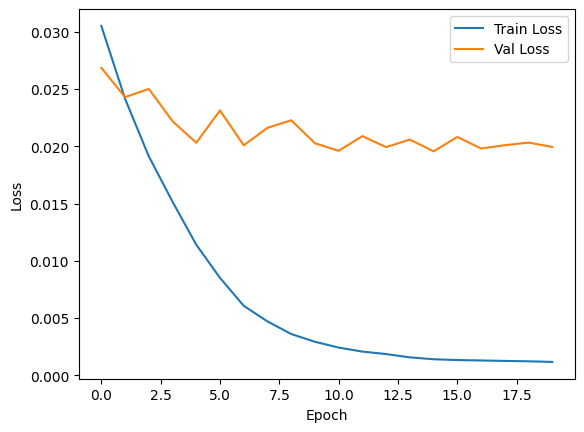

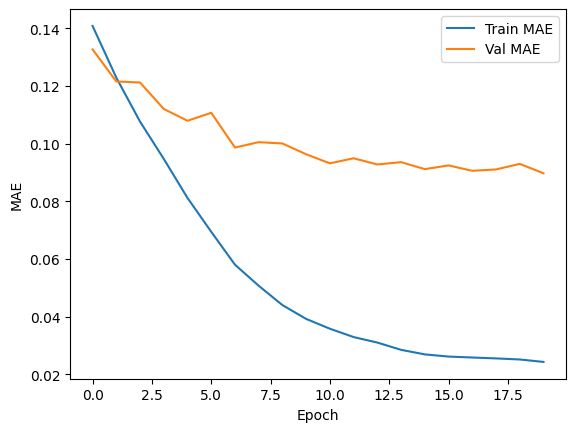

In [50]:
# X_train, y_train are training data and labels
# Convert them to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

print(y_val_tensor)
# Create a TensorDataset and a DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Initialize the model, loss function, and optimizer
model = FCNN()
loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters())

# Lists to store loss values for each epoch
train_losses = []
val_losses = []
train_maes = []
val_maes = []

n_epochs = 20

for epoch in range(n_epochs):
    train_loss = 0
    val_loss = 0
    train_mae = 0
    val_mae = 0

    # Training loop
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Compute MAE
        mae = torch.mean(torch.abs(outputs - labels))
        train_mae += mae.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            # Compute MAE
            mae = torch.mean(torch.abs(outputs - labels))
            val_mae += mae.item()

    # Record average losses for this epoch
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    train_maes.append(train_mae / len(train_dataloader))
    val_maes.append(val_mae / len(val_dataloader))

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train MAE: {train_maes[-1]}, Val MAE: {val_maes[-1]}')

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

### FCNN with Rdkit descriptors

In [38]:
# concatenate arrays in one column to 2D column arrays for the rdkit descriptors
compound_descriptors = np.stack(df_fp['productSmiles_processed_RDKit_Descriptors'].values)
solvent_A_descriptors = np.stack(df_fp['Solvent_A_Smiles_RDKit_Descriptors'].values)
solvent_B_descriptors = np.stack(df_fp['Solvent_B_Smiles_RDKit_Descriptors'].values)
percent_a_features = np.stack(df_fp['Percent_A'].values)
percent_b_features = np.stack(df_fp['Percent_B'].values)

# concatenate all the 2D numpy arrays to a big 2D numpy array
descriptors = np.concatenate([compound_descriptors, solvent_A_descriptors, solvent_B_descriptors, percent_a_features, percent_b_features], axis=1)
y = np.stack(df_fp['Rf'].values)
print(descriptors.shape, type(descriptors), descriptors.ndim, y.ndim, y.shape)

(15062, 14) <class 'numpy.ndarray'> 2 2 (15062, 1)


In [41]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(descriptors, y, test_size=0.2, random_state=42)

Epoch 1/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 500.5640 - mae: 10.1714 - val_loss: 0.3020 - val_mae: 0.4266
Epoch 2/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2885 - mae: 0.4007 - val_loss: 0.2303 - val_mae: 0.3762
Epoch 3/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1992 - mae: 0.3350 - val_loss: 0.1728 - val_mae: 0.3180
Epoch 4/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1597 - mae: 0.3036 - val_loss: 0.1532 - val_mae: 0.3029
Epoch 5/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1242 - mae: 0.2719 - val_loss: 0.1177 - val_mae: 0.2705
Epoch 6/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1032 - mae: 0.2488 - val_loss: 0.0871 - val_mae: 0.2291
Epoch 7/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1010 - mae: 0.2462 - val_loss: 0.0815 - val_mae: 0.2211
Epoch 8/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0829 - mae: 0.2257 - val_loss: 0.0764 - val_mae: 0.2146
Epoch 9/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

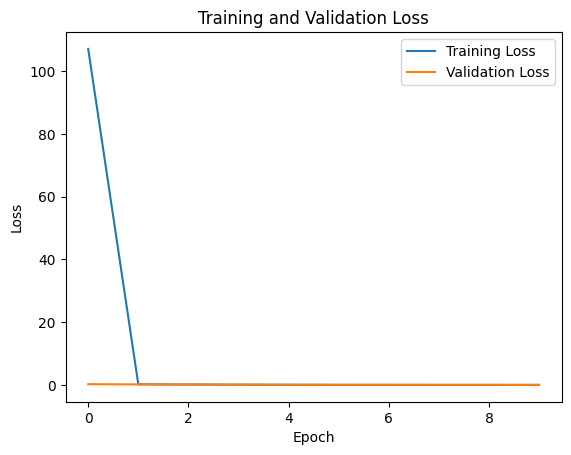

In [44]:
# Create a Sequential model
model = Sequential()

# Define input layer with 14 input features (from shape of X_train)
model.add(Dense(64, activation='relu', input_shape=(14,)))

# Add additional dense layers
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

# Output layer to predict Rf value
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)

# Print test loss and mean absolute error
print("Test Loss:", loss)
print("Test MAE:", mae)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### FCNN with embedded NN

Epoch 1/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - loss: 1.5502 - mae: 0.6334 - val_loss: 0.1974 - val_mae: 0.4046
Epoch 2/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - loss: 0.1983 - mae: 0.4051 - val_loss: 0.1974 - val_mae: 0.4046
Epoch 3/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - loss: 0.1965 - mae: 0.4031 - val_loss: 0.1974 - val_mae: 0.4046
Epoch 4/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 28s 92ms/step - loss: 0.1952 - mae: 0.4020 - val_loss: 0.1974 - val_mae: 0.4046
Epoch 5/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - loss: 0.1977 - mae: 0.4049 - val_loss: 0.1974 - val_mae: 0.4046
Epoch 6/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 37s 68ms/step - loss: 0.1950 - mae: 0.4020 - val_loss: 0.1974 - val_mae: 0.4046
Epoch 7/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - loss: 0.1944 - mae: 0.4014 - val_loss: 0.1974 - val_mae: 0.4046
Epoch 8/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - loss: 0.1950 - mae: 0.4014 - val_loss: 0.1974 - val_mae: 0.4046
Epoch 9/10
302/302 ━━━━━━━━━━━━━━━━━━━━ 

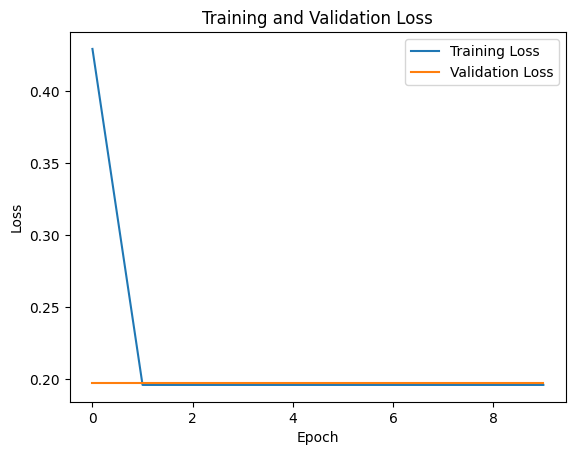

In [ ]:
# Split data into training and test sets
X_train_smiles_1, X_test_smiles_1, X_train_smiles_2, X_test_smiles_2, X_train_smiles_3, X_test_smiles_3, X_train_percentage_a, X_test_percentage_a, X_train_percentage_b, X_test_percentage_b, y_train, y_test = train_test_split(
    compound_features, solvent_A_features, solvent_B_features, percent_a_features, percent_b_features, y, test_size=0.2, random_state=42)

# Define input layers for SMILES and percentage features
smiles_input_1 = Input(shape=(2048,))
smiles_input_2 = Input(shape=(2048,))
smiles_input_3 = Input(shape=(2048,))
percentage_input_a = Input(shape=(1,))  
percentage_input_b = Input(shape=(1,))

# Define neural networks for SMILES columns to reduce dimension of input
# compound
smiles_nn_1 = Dense(1024, activation='relu')(smiles_input_1)
smiles_nn_1 = Dense(512, activation='relu')(smiles_nn_1)
smiles_output_1 = Dense(128, activation='relu')(smiles_nn_1)

# solvent A
smiles_nn_2 = Dense(512, activation='relu')(smiles_input_2)
smiles_nn_2 = Dense(128, activation='relu')(smiles_nn_2)
smiles_output_2 = Dense(32, activation='relu')(smiles_nn_2)

# solvent B
smiles_nn_3 = Dense(512, activation='relu')(smiles_input_3)
smiles_nn_3 = Dense(128, activation='relu')(smiles_nn_3)
smiles_output_3 = Dense(32, activation='relu')(smiles_nn_3)

# Concatenate SMILES outputs with percentage features
concatenated = Concatenate()([smiles_output_1, smiles_output_2, smiles_output_3, percentage_input_a, percentage_input_b])

# Additional layers for further processing
hidden_layer = Dense(64, activation='relu')(concatenated)
hidden_layer = Dense(32, activation='relu')(hidden_layer)
output_layer = Dense(1, activation='linear')(hidden_layer)

# Define the model
model = Model(inputs=[smiles_input_1, smiles_input_2, smiles_input_3, percentage_input_a, percentage_input_b], outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model and record the history
history = model.fit([X_train_smiles_1, X_train_smiles_2, X_train_smiles_3, X_train_percentage_a, X_train_percentage_b], y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, mae = model.evaluate([X_test_smiles_1, X_test_smiles_2, X_test_smiles_3, X_test_percentage_a, X_test_percentage_b], y_test)

# Print test loss and mean absolute error
print("Test Loss:", loss)
print("Test MAE:", mae)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## 5.3 RandomForestRegression Model

Import packages for RandomForest Regressor

In [6]:
from sklearn.ensemble import RandomForestRegressor

Preprocess again all the data into a feature matrix (just wanted to try it with another stacking method here)

In [7]:
# Combine all features into a single 2D numpy array
X = np.hstack([
    np.vstack(df_fp['productSmiles_processed_Morgan_Fingerprint_np'].values),
    np.vstack(df_fp['Solvent_A_Smiles_Morgan_Fingerprint_np'].values),
    np.vstack(df_fp['Solvent_B_Smiles_Morgan_Fingerprint_np'].values),
    np.vstack(df_fp['Percent_A'].values),
    np.vstack(df_fp['Percent_B'].values)
])

y = np.vstack(df_fp['Rf'].values).flatten()  # Flatten to get a 1D array

In [8]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Random Forest - Mean Squared Error: 0.015674800020763036
Random Forest - R^2 Score: 0.5332279430548992


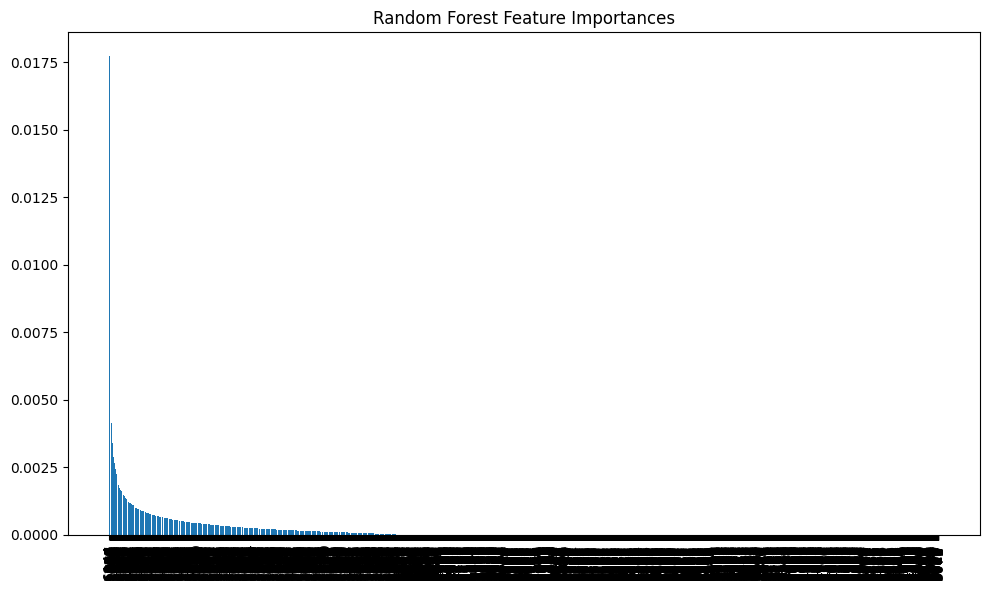

In [9]:
# Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Evaluate the Random Forest model
y_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - R^2 Score: {r2_rf}")

# Feature importance plot
feature_importances_rf = model_rf.feature_importances_
indices_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.bar(range(X.shape[1]), feature_importances_rf[indices_rf], align="center")
plt.xticks(range(X.shape[1]), indices_rf, rotation=90)
plt.tight_layout()
plt.show()

## 5.5 GradientBoostingRegressor Model - XGBoost

In [15]:
import xgboost as xgb
import optuna

Use same pre-processing as before.

In [11]:
# Combine all features into a single feature matrix
X = np.hstack([
    np.vstack(df_fp['productSmiles_processed_Morgan_Fingerprint_np'].values),
    np.vstack(df_fp['Solvent_A_Smiles_Morgan_Fingerprint_np'].values),
    np.vstack(df_fp['Solvent_B_Smiles_Morgan_Fingerprint_np'].values),
    np.vstack(df_fp['Percent_A'].values),
    np.vstack(df_fp['Percent_B'].values)
])

# Prepare the target variable
y = np.vstack(df_fp['Rf'].values).flatten()

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# use optuna for hyperparameter tuning
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1e-1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1e-1),
        'random_state': 42
    }
    
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds=10, verbose=False)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.18191
[1]	validation_0-rmse:0.18076
[2]	validation_0-rmse:0.17948
[3]	validation_0-rmse:0.17865
[4]	validation_0-rmse:0.17759
[5]	validation_0-rmse:0.17688
[6]	validation_0-rmse:0.17607
[7]	validation_0-rmse:0.17530
[8]	validation_0-rmse:0.17471
[9]	validation_0-rmse:0.17412
[10]	validation_0-rmse:0.17357
[11]	validation_0-rmse:0.17321
[12]	validation_0-rmse:0.17268
[13]	validation_0-rmse:0.17202
[14]	validation_0-rmse:0.17149
[15]	validation_0-rmse:0.17098
[16]	validation_0-rmse:0.17073
[17]	validation_0-rmse:0.17042
[18]	validation_0-rmse:0.17003
[19]	validation_0-rmse:0.16966
[20]	validation_0-rmse:0.16929
[21]	validation_0-rmse:0.16903
[22]	validation_0-rmse:0.16872
[23]	validation_0-rmse:0.16841
[24]	validation_0-rmse:0.16800
[25]	validation_0-rmse:0.16773
[26]	validation_0-rmse:0.16748
[27]	validation_0-rmse:0.16723
[28]	validation_0-rmse:0.16702
[29]	validation_0-rmse:0.16691
[30]	validation_0-rmse:0.16670
[31]	validation_0-rmse:0.16644
[32]	validation_0-

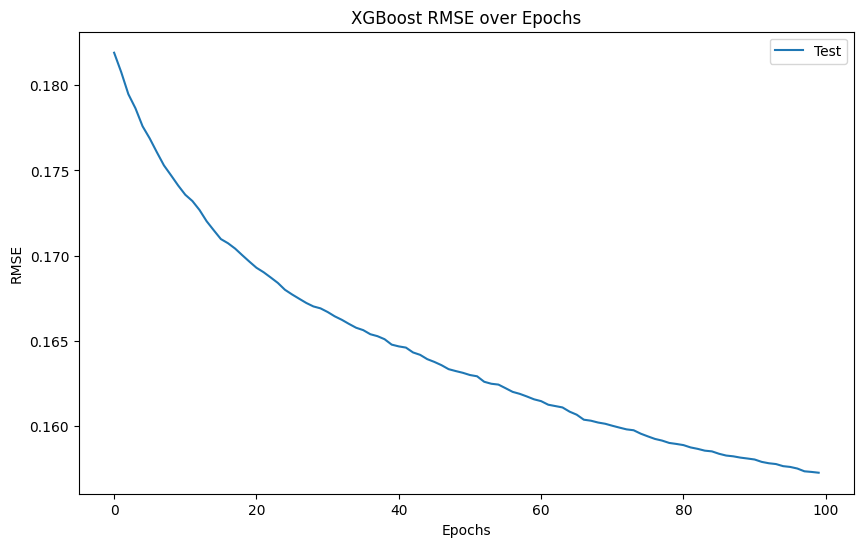

In [13]:
# XGBoost Regressor
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds=10, verbose=True)

# Evaluate the XGBoost model
y_pred_xgb = model_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - Mean Squared Error: {mse_xgb}")
print(f"XGBoost - R^2 Score: {r2_xgb}")

# Plotting the evaluation results
results = model_xgb.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Test')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE over Epochs')
plt.legend()
plt.show()

In [18]:
# XGBoost Regressor with Optuna hyperparameter tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print(f"Best hyperparameters: {study.best_params}")

# Train the model with the best hyperparameters
best_params = study.best_params
model_xgb = xgb.XGBRegressor(**best_params)
model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds=10, verbose=True)

# Evaluate the model
y_pred_xgb = model_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - Mean Squared Error: {mse_xgb}")
print(f"XGBoost - R^2 Score: {r2_xgb}")

# Plotting the evaluation results
results = model_xgb.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Test')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE over Epochs')
plt.legend()
plt.show()

[I 2024-05-15 10:07:20,555] A new study created in memory with name: no-name-83025231-d2ca-4042-9667-115e8d79978f
C:\Users\milen\AppData\Local\Temp\ipykernel_16192\668131634.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\milen\AppData\Local\Temp\ipykernel_16192\668131634.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\milen\AppData\Local\Temp\ipykernel_16192\668131634.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

KeyboardInterrupt: 

## 5.4 Ensemble Learning

### Stacking

In [45]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

# Initialize base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
]

# Train base models
train_meta_features = np.zeros((X_train.shape[0], len(base_models)))
test_meta_features = np.zeros((X_test.shape[0], len(base_models)))

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (name, model) in enumerate(base_models):
    for train_index, val_index in kf.split(X_train):
        model.fit(X_train[train_index], y_train[train_index])
        train_meta_features[val_index, i] = model.predict(X_train[val_index])
    model.fit(X_train, y_train)
    test_meta_features[:, i] = model.predict(X_test)

# Train meta-model
meta_model = LinearRegression()
meta_model.fit(train_meta_features, y_train)

# Predict and evaluate
y_pred = meta_model.predict(test_meta_features)
mse = mean_squared_error(y_test, y_pred)
print(f"Stacking - Mean Squared Error: {mse}")

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


KeyboardInterrupt: 

### Bagging
(Boostrap Aggregating = training multiple models on different subsets of the data and averaging the predictions)

In [ ]:
from sklearn.ensemble import BaggingRegressor

model_bagging = BaggingRegressor(base_estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_estimators=10, random_state=42)
model_bagging.fit(X_train, y_train)
y_pred_bagging = model_bagging.predict(X_test)

mse_bagging = mean_squared_error(y_test, y_pred_bagging)
print(f"Bagging - Mean Squared Error: {mse_bagging}")

### Hybrid Models

NN embeddings as input features to Random Forest

In [22]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Train Embedding Neural Network
embedding_model = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Adjust embedding size as needed
])
embedding_model.compile(optimizer='adam', loss='mean_squared_error')
embedding_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Generate Embeddings
X_train_embeddings = embedding_model.predict(X_train)
X_test_embeddings = embedding_model.predict(X_test)

# Train Random Forest Model
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_embeddings, y_train)

# Train XGBoost Model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model_xgb.fit(X_train_embeddings, y_train, eval_set=[(X_test_embeddings, y_test)], eval_metric='rmse', early_stopping_rounds=10, verbose=True)

# Generate Predictions
y_pred_rf = model_rf.predict(X_test_embeddings)
y_pred_xgb = model_xgb.predict(X_test_embeddings)

# Evaluate Hybrid Model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - R^2 Score: {r2_rf}")

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost - Mean Squared Error: {mse_xgb}")
print(f"XGBoost - R^2 Score: {r2_xgb}")

Epoch 1/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - loss: 0.0736 - val_loss: 0.0334
Epoch 2/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 0.0337 - val_loss: 0.0321
Epoch 3/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 0.0302 - val_loss: 0.0304
Epoch 4/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 0.0280 - val_loss: 0.0276
Epoch 5/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0251 - val_loss: 0.0265
Epoch 6/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - loss: 0.0225 - val_loss: 0.0252
Epoch 7/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 0.0206 - val_loss: 0.0237
Epoch 8/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0188 - val_loss: 0.0242
Epoch 9/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.0168 - val_loss: 0.0219
Epoch 10/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0146 - val_loss: 0.0216
Epoch 11/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0147 - val_loss: 0.0223
Epoch 12/50
302/302 ━━━━━━━━━━

c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\milen\anaconda3\envs\ppchem\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Random Forest - Mean Squared Error: 0.019957787098663894
Random Forest - R^2 Score: 0.4056870056539159
XGBoost - Mean Squared Error: 0.018870959633685132
XGBoost - R^2 Score: 0.4380510990203761
